In [22]:
from langgraph.graph import StateGraph ,START , END , add_messages
from typing import TypedDict , Annotated , Literal
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel , Field
from langchain_core.messages import HumanMessage , SystemMessage
import os
load_dotenv()
GROQ_API_KEY = os.getenv('GROQ_API_KEY1')
import operator

In [23]:
generator_llm = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)
evaluator_llm = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)
optimizer_llm = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)


In [24]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved' , 'needs_improvement']
    feedback: str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str] , operator.add]
    feedback_history: Annotated[list[str] , operator.add]

In [25]:
class TweetEvaluation(BaseModel):
    evaluation: Literal['approved' , 'needs_improvement'] = Field(... , description='final evaluation result.')
    feedback: str = Field(... , description="Constructive feedback for the tweet.")


evaluator_llm_2 = evaluator_llm.with_structured_output(TweetEvaluation)

In [ ]:
def generation(state: TweetState):

    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer"),
        HumanMessage(content=f"Write a small original and hilarious tweet on the topic '{state['topic']}'")
    ]
    response = generator_llm.invoke(messages).content
    return {'tweet': response , 'tweet_history': [response]}



def evaluation(state: TweetState):
    messages = [
        SystemMessage(content="you are a ruthless tweet evaluator"),
        HumanMessage(content=f"""Evaluate the following tweet: {state['tweet']}
        Respond only in structured format:
        evaluation: "approved" or "needs_improvement" 
        feedback: One paragraph explaining the strengths and weakness 
        """)
    ]
    
    response = evaluator_llm_2.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback , 'feedback_history': [response.feedback]}

    
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback"),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
'{state['feedback']}'

Topic: '{state['topic']}'
Original Tweet:
{state['tweet']}                                        
Rewrite it as a short , viral-worthy tweet. Avoid Q&A style under 200 characters.""")]
    

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration']+1


    return {'tweet': response , 'iteration': iteration , 'tweet_history': [response]}

In [31]:
def routeEval(state: TweetState):
    if state['evaluation'] == "approved" or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else: 'needs_improvement'

In [36]:
graph = StateGraph(TweetState)

graph.add_node("generation" , generation)
graph.add_node("evaluation" , evaluation)
graph.add_node('optimize_tweet' , optimize_tweet)

In [37]:
graph.add_edge(START , "generation")
graph.add_edge("generation" , "evaluation")
graph.add_conditional_edges("evaluation" , routeEval , {'approved': END , 'needs_improvement': 'optimize_tweet'})

graph.add_edge('optimize_tweet' , 'evaluation')

app = graph.compile()

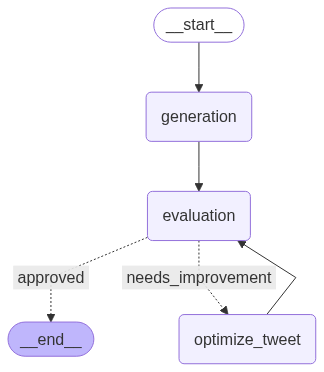

In [9]:
app

In [38]:
initial_state = {
    "topic": "Layoffs in the IT companies",
    "iteration":1,
    "max_iteration":3
}

app.invoke(initial_state)


{'topic': 'Layoffs in the IT companies',
 'tweet': AIMessage(content='"Just got laid off from my IT job and I\'m not mad, I\'m just experiencing a little \'glitch\' in my career. On the bright side, I\'ve been \'downsized\' to a life of playing video games in my PJs and eating Cheetos for breakfast. Anyone need a freelance couch surfer? #ITlife #LayoffLols"', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 44, 'total_tokens': 123, 'completion_time': 0.372927573, 'prompt_time': 0.001026333, 'queue_time': 0.27414902, 'total_time': 0.373953906}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'finish_reason': 'stop', 'logprobs': None}, id='run--40aae5e6-b8e0-438c-be15-fbb17ed624c0-0', usage_metadata={'input_tokens': 44, 'output_tokens': 79, 'total_tokens': 123}),
 'evaluation': 'approved',
 'feedback': "This tweet is well-crafted, using clever wordplay and humor to spin a negative situation into a lighthearted, rel